## SPHEREx power spectrum 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import astropy.units as u 
import astropy.constants as cu 
import oLIMpus.analysis as a 
from oLIMpus import eor_colour, LIM_colour_1
from oLIMpus import CoevalBox_LIM_analytical
from oLIMpus import SFR_II, rhoL_integrand
import powerbox as pb
from scipy.interpolate import RegularGridInterpolator, interp1d

Set parameters for the run.

## COSMOLOGY???

In [2]:
# set user parameters, see inputs.py for details
UP = a.User_Parameters(
            precisionboost= 1.0, 
            FLAG_FORCE_LINEAR_CF= 0, 
            MIN_R_NONLINEAR= 1, 
            MAX_R_NONLINEAR= 200.0,
            FLAG_DO_DENS_NL= False, 
            FLAG_WF_ITERATIVE= True,
            )

CosmoParams_input_fid = dict(
        omegab= 0.0223828, 
        omegac = (0.315*0.674**2 - 0.0223828), 
        h_fid = 0.674, 
        As = 2.100549e-09, 
        ns = 0.9660499, 
        tau_fid = 0.05430842, 
        HMF_CHOICE= "ST",
        Flag_emulate_21cmfast = False,
        zmin_CLASS = 0.
        )


# set fiducial cosmology, run CLASS and get the halo mass function
CP_fid, ClassyC_fid, zeus_corr_fid, HMFcl_fid = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**CosmoParams_input_fid))

In [54]:
set_scatter = 0.

SFR parameters, by default we use GALLUMI (see sfrd.py for details)

In [55]:
AstroParams_input_fid = dict(

        astromodel = 0,
        accretion_model = 0,
        alphastar = 0.5,
        betastar = -0.5,
        epsstar = 0.1,
        Mc = 3e11,
        Mturn_fixed = None,
        dlog10epsstardz = 0.0,
        quadratic_SFRD_lognormal = True,
         
        fesc10 = 0.1,
        alphaesc = 0.,
        L40_xray = 3.0,
        E0_xray = 500.,
        alpha_xray = -1.0,
        Emax_xray_norm=2000,

        Nalpha_lyA_II = 9690,
        Nalpha_lyA_III = 17900,

        FLAG_MTURN_SHARP= False,

        C0dust = 4.43,
        C1dust = 1.99,
        sigmaUV=0.5,

        USE_POPIII = False,
        alphastar_III = 0, 
        betastar_III = 0,
        fstar_III = 10**(-2.5),
        Mc_III = 1e7,
        dlog10epsstardz_III = 0.0,
        fesc7_III = 10**(-1.35),
        alphaesc_III = -0.3,
        L40_xray_III = 3.0,
        alpha_xray_III = -1.0,        
        USE_LW_FEEDBACK = False,
        A_LW = 2.0,
        beta_LW = 0.6,
        A_vcb = 1.0,
        beta_vcb = 1.8,
        )

AP_fid = a.zeus21.Astro_Parameters(UP, CP_fid, **AstroParams_input_fid)


The following are the default parameters to run OIII.
In particular note that
- LINE : you can choose 'OIII4960' or 'OIII5007'
- LINE_MODEL : you can choose between 'Yang24' and 'THESAN'; see LIM_luminosities.py for details
- _R : down to which scale the power spectrum is computed, >= 1 Mpc to trust the modeling
- sigma_LMh : scattering in the line-Mh or line-SFR relations, see LIM_modeling.py; 
- line_dict : if None, it uses the default parameters defined at the bottom of LIM_luminosities.py

In [56]:
# set line parameters
LineParams_Yang24 = a.LineParams_Input(
            LINE = 'OIII5007', # which line
            LINE_MODEL = 'Yang24', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in uK (Tnu)
            _R = 1., # resolution for smoothing (Mpc)
            stoch_type='median',
            sigma_LMh = set_scatter*u.dex, # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True, # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
            line_dict = None,
        )

LP = a.Line_Parameters(LineParams_Yang24,UP)


LineParams_SFR = a.LineParams_Input(
            LINE = 'SFRD', # which line
            LINE_MODEL = 'powerlaw', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in uK (Tnu)
            _R = 1., # resolution for smoothing (Mpc)
            stoch_type='median',
            sigma_LMh = set_scatter*u.dex, # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True, # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
            line_dict = {'alpha_SFR':1.}
        )

LP_SFR = a.Line_Parameters(LineParams_SFR,UP)


In [57]:
# general properties
ZMIN = 3. # down to which redshift perform the computation
RSD_MODE = 0 # 0 if comoving distance, 1 to get spherically averaged RSD (mu = 0.6)

Run oLIMpus to get the classes that contain the LIM power spectrum.

In [58]:
LIM_coeff = a.get_LIM_coefficients(LP, AP_fid, CP_fid, HMFcl_fid, UP, zmin=ZMIN)
LIM_corr = a.Correlations_LIM(LP, CP_fid, ClassyC_fid)
LIM_pk = a.Power_Spectra_LIM(LIM_corr, LIM_coeff, LP, CP_fid, UP, RSD_MODE=RSD_MODE)

LIM_coeff_SFR = a.get_LIM_coefficients(LP_SFR, AP_fid, CP_fid, HMFcl_fid, UP, zmin=ZMIN)
LIM_corr_SFR = a.Correlations_LIM(LP_SFR, CP_fid, ClassyC_fid)
LIM_pk_SFR = a.Power_Spectra_LIM(LIM_corr_SFR, LIM_coeff_SFR, LP_SFR, CP_fid, UP, RSD_MODE=RSD_MODE)

## REDSHIFT

In [59]:
z = 4.

In [60]:
dndM_oLIMpus = RegularGridInterpolator((HMFcl_fid.Mhtab,HMFcl_fid.zHMFtab),HMFcl_fid.HMFtab)
dndM_oLIMpus = np.exp(HMFcl_fid.logHMFint((np.log(HMFcl_fid.Mhtab), z)))

Text(0, 0.5, '$dn/dM_h$')

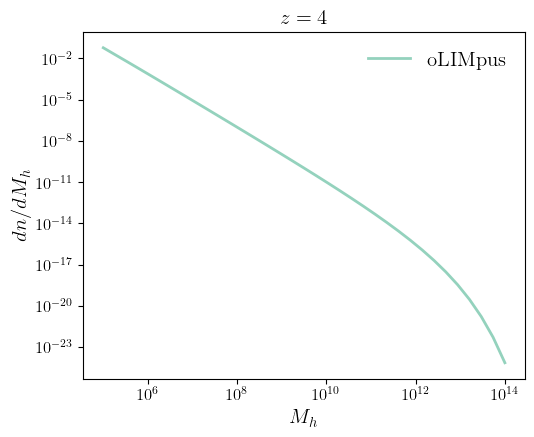

In [61]:
plt.loglog(HMFcl_fid.Mhtab, dndM_oLIMpus,label=r'$\rm oLIMpus$',color=a.colors[3])
plt.legend()
plt.title(r'$z=%g$'%z)
plt.xlabel(r'$M_h$')
plt.ylabel(r'$dn/dM_h$')
#plt.ylim(1e-20,1e-1)

In [62]:
marr, zarr = np.meshgrid(HMFcl_fid.Mhtab,HMFcl_fid.zHMFtab)
sfr_oLIMpus = SFR_II(AP_fid,CP_fid,HMFcl_fid,marr, zarr, zarr)
sfr_oLIMpus_interp = RegularGridInterpolator((HMFcl_fid.Mhtab,HMFcl_fid.zHMFtab),sfr_oLIMpus.T)

(10000000000.0, 10000000000000.0)

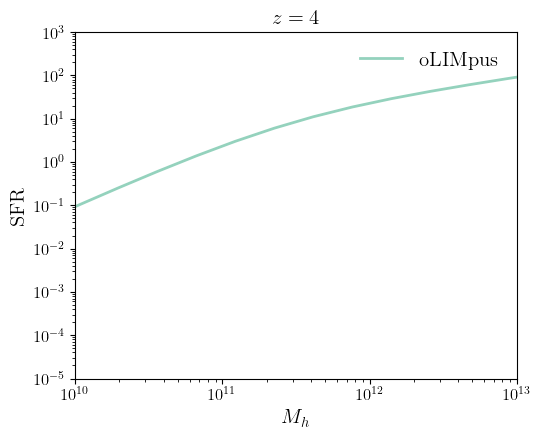

In [63]:
plt.loglog(HMFcl_fid.Mhtab,sfr_oLIMpus_interp((HMFcl_fid.Mhtab,z)),label=r'$\rm oLIMpus$',color=a.colors[3])
plt.legend()
plt.title(r'$z=%g$'%z)
plt.xlabel(r'$M_h$')
plt.ylabel(r'$\rm SFR$')
plt.ylim(1e-5,1e3)
plt.xlim(1e10,1e13)

In [13]:
zLIM_longer = np.geomspace(ZMIN, 50, 128) #extend to z = 50 for extrapolation purposes
zLIM, mArray_LIM = np.meshgrid(zLIM_longer, HMFcl_fid.Mhtab, indexing = 'ij', sparse = True)

rhoL = RegularGridInterpolator((zLIM_longer,HMFcl_fid.Mhtab),rhoL_integrand(False, LP, AP_fid, CP_fid, HMFcl_fid, mArray_LIM, zLIM)/mArray_LIM)
rhoSFR = RegularGridInterpolator((zLIM_longer,HMFcl_fid.Mhtab),rhoL_integrand(False, LP_SFR, AP_fid, CP_fid, HMFcl_fid, mArray_LIM, zLIM)/mArray_LIM)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:39: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:41: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:8: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L)


(1e-50, 10.0)

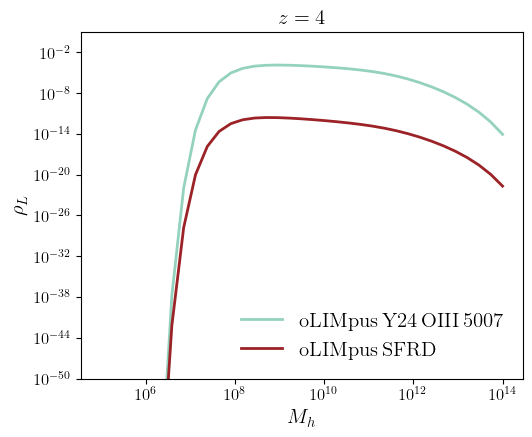

In [14]:
plt.loglog(HMFcl_fid.Mhtab,rhoL((z,HMFcl_fid.Mhtab)),label=r'$\rm oLIMpus\,Y24\,OIII\,5007$',color=a.colors[3])
plt.loglog(HMFcl_fid.Mhtab,rhoSFR((z,HMFcl_fid.Mhtab)),label=r'$\rm oLIMpus\,SFRD$',color=a.colors[-1])

plt.legend()
plt.title(r'$z=%g$'%z)
plt.xlabel(r'$M_h$')
plt.ylabel(r'$\rho_L$')
plt.ylim(1e-50,1e1)

In [15]:
Imean_oLIMpus = interp1d(LIM_coeff.zintegral,LIM_coeff.rhoL_avg)
SFRDmean_oLIMpus = interp1d(LIM_coeff.zintegral,LIM_coeff_SFR.rhoL_avg)

In [16]:
print('oLIMpus mean observed I_OIII mean = ' + str(Imean_oLIMpus(z)))
print('oLIMpus mean observed SFRD mean = ' + str(SFRDmean_oLIMpus(z)))

oLIMpus mean observed I_OIII mean = 7862376.56793102
oLIMpus mean observed SFRD mean = 0.08207033651320408


In [17]:
pk_oLIMpus = RegularGridInterpolator((LIM_coeff.zintegral,LIM_pk.klist_PS),LIM_pk._Pk_LIM_tot)
pk_shot_oLIMpus = RegularGridInterpolator((LIM_coeff.zintegral,LIM_pk.klist_PS),LIM_pk.P_shot_noise)

pk_oLIMpus_SFR = RegularGridInterpolator((LIM_coeff_SFR.zintegral,LIM_pk_SFR.klist_PS),LIM_pk_SFR._Pk_LIM_tot)
pk_shot_oLIMpus_SFR = RegularGridInterpolator((LIM_coeff_SFR.zintegral,LIM_pk_SFR.klist_PS),LIM_pk_SFR.P_shot_noise)

Text(0, 0.5, '$P_{\\rm 2h+shot}(k)$')

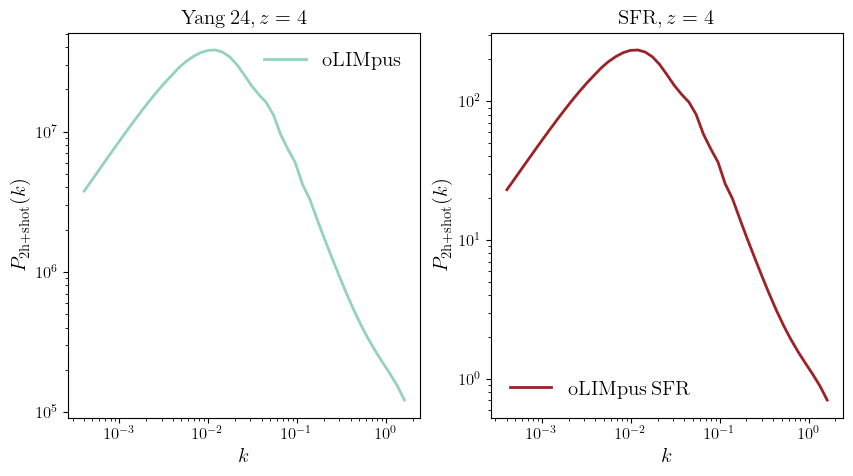

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title(r'$\rm Yang\,24,\,$'+r'$z=%g$'%z)
plt.loglog(LIM_pk.klist_PS,pk_oLIMpus((z,LIM_pk.klist_PS)),label=r'$\rm oLIMpus$',color=a.colors[3],ls='-')
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$P_{\rm 2h+shot}(k)$')

plt.subplot(122)
plt.title(r'$\rm SFR,\,$'+r'$z=%g$'%z)
plt.loglog(LIM_pk_SFR.klist_PS,pk_oLIMpus_SFR((z,LIM_pk.klist_PS)),label=r'$\rm oLIMpus\,SFR$',color=a.colors[-1],ls='-')
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$P_{\rm 2h+shot}(k)$')

### Create maps

To get the LIM coeval box we use the maps_LIM.py module.

In [19]:
# properties to compute the coeval boxes
zbox = z
Lbox = 200
Nbox = 50
seed = 333
LIM_boxes = CoevalBox_LIM_analytical(LIM_coeff,
                                     LIM_corr,
                                     LIM_pk,
                                     LP,
                                     zbox,
                                     LP._R,
                                     Lbox=Lbox,
                                     Nbox=Nbox, 
                                     RSD=RSD_MODE, 
                                     get_density_box=False,
                                     seed=seed)

LIM_boxes_SFR = CoevalBox_LIM_analytical(LIM_coeff_SFR,
                                     LIM_corr_SFR,
                                     LIM_pk_SFR,
                                     LP_SFR,
                                     zbox,
                                     LP_SFR._R,
                                     Lbox=Lbox,
                                     Nbox=Nbox, 
                                     RSD=RSD_MODE, 
                                     get_density_box=True,
                                     seed=seed)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/powerbox/powerbox.py:396: RuntimeWarning: invalid value encountered in log
  return np.log(1 + self.correlation_array())


## NO SMOOTHING

In [20]:
# line 
box_LIM = LIM_boxes.Inu_box
# line without shot noise
box_LIM_noSN = LIM_boxes.Inu_box_noiseless

# line 
box_SFR = LIM_boxes_SFR.Inu_box
# line without shot noise
box_SFR_noSN = LIM_boxes_SFR.Inu_box_noiseless

In [21]:
zlist = LIM_coeff.zintegral 
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-z)) #pick closest z
        
klist = LIM_pk_SFR.klist_PS
Pnu = LIM_pk_SFR._Pk_LIM[_iz,:]

Pnu_interp = interp1d(klist,Pnu,fill_value=0.0,bounds_error=False)
pbb = pb.LogNormalPowerBox(
                N=Nbox,                     
                dim= 3,                     
                pk = lambda k: Pnu_interp(k), 
                boxlength = Lbox,           
                seed = seed,
            )
SFRD_box_noiseless = pbb.delta_x() + LIM_coeff_SFR.Inu_bar[_iz]

Pshot_interp = lambda k: LIM_coeff_SFR.shot_noise[_iz]

pb_shot = pb.PowerBox(
    N=Nbox,                     
    dim= 3,                     
    pk = lambda k: Pshot_interp(k), 
    boxlength = Lbox,           
    seed = seed+2, # uncorrelated from the density field
)

shotnoise_box = pb_shot.delta_x() + LIM_coeff.shot_noise[_iz] # shot noise box
SFRD_box = SFRD_box_noiseless + shotnoise_box

Let's plot them.

Text(0.5, 1.0, '$z=4$')

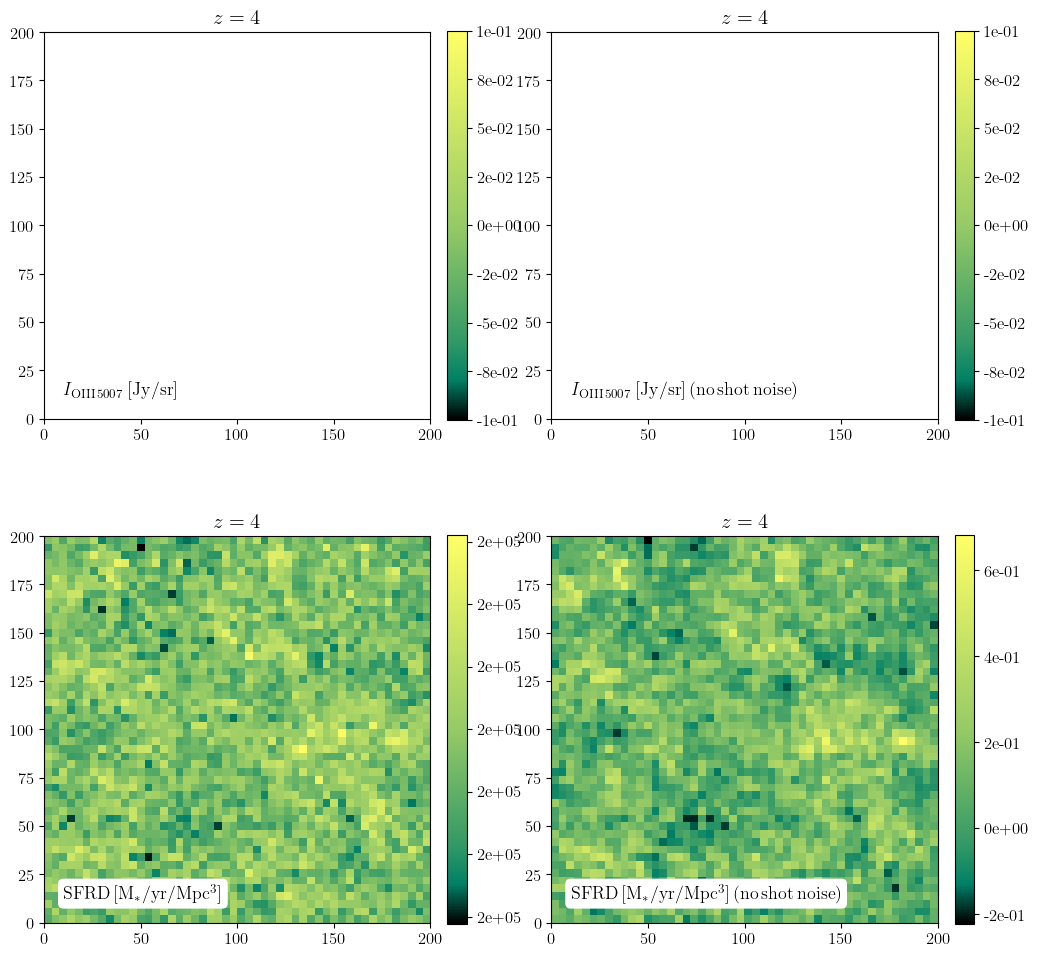

In [22]:
_islice = 0 # which slice

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# LIM 
im = ax[0,0].imshow(box_LIM[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[0,0], fraction=0.046, pad=0.04, format="%.0e")

ax[0,0].text(
    0.05, 0.05, r'$I_{\rm OIII\,5007}\,[{\rm Jy/sr}]$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[0,0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

ax[0,0].set_title(r'$z=%g$'%zbox)

# LIM no shot noise
im = ax[0,1].imshow(box_LIM_noSN[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[0,1], fraction=0.046, pad=0.04, format="%.0e")

ax[0,1].text(
    0.05, 0.05, r'$I_{\rm OIII\,5007}\,[{\rm Jy/sr}]\,({\rm no\,shot\,noise})$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[0,1].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

ax[0,1].set_title(r'$z=%g$'%zbox)


# SFR 
im = ax[1,0].imshow(SFRD_box[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[1,0], fraction=0.046, pad=0.04, format="%.0e")

ax[1,0].text(
    0.05, 0.05, r'${\rm SFRD}\,[{\rm M_*/yr/Mpc^3}]$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[1,0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

ax[1,0].set_title(r'$z=%g$'%zbox)

# LIM no shot noise
im = ax[1,1].imshow(SFRD_box_noiseless[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[1,1], fraction=0.046, pad=0.04, format="%.0e")

ax[1,1].text(
    0.05, 0.05, r'${\rm SFRD}\,[{\rm M_*/yr/Mpc^3}]\,({\rm no\,shot\,noise})$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[1,1].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

ax[1,1].set_title(r'$z=%g$'%zbox)


Finally, let's have a look at the theoretical LIM power spectrum, compared with the power spectra measured from the boxes.

Text(0.5, 1.0, '${\\rm SFR}, z=4$')

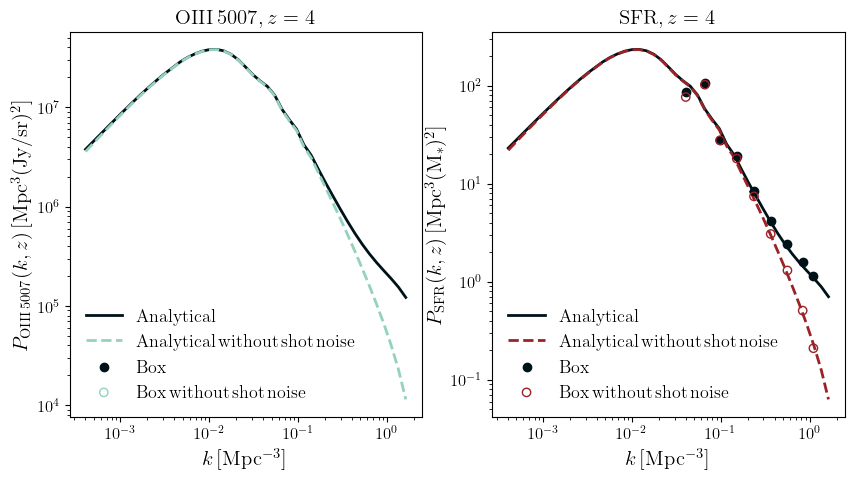

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),)

# LIM
# theory power spectrum
klist = LIM_corr._klistCF
iz_val = min(range(len(LIM_coeff.zintegral)), key=lambda i: np.abs((LIM_coeff.zintegral[i]-zbox))) # which z 

Pk_analytical = LIM_pk._Pk_LIM_tot 
Pk_analytical_noSN = LIM_pk._Pk_LIM_RSD

# from the boxes
k_bins = np.logspace(np.log10(2*np.pi/Lbox),np.log10(2*np.pi/Lbox*Nbox),10) # define the k array 

pk_LIM, k_LIM = pb.get_power(
    deltax = box_LIM,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_LIM_noSN, _ = pb.get_power(
    deltax = box_LIM_noSN,
    boxlength= Lbox,
    bins = k_bins,
    ) 


axes[0].loglog(klist,Pk_analytical[iz_val],color=a.colors[0],label=r'${\rm Analytical}$')
axes[0].loglog(klist,Pk_analytical_noSN[iz_val],color=a.colors[3],label=r'${\rm Analytical\,without\,shot\,noise}$',ls='--')

axes[0].scatter(k_LIM,pk_LIM,color=a.colors[0],marker='o',zorder=8,label=r'$\rm Box$')
axes[0].scatter(k_LIM,pk_LIM_noSN,color=a.colors[3],marker='o',zorder=8,label=r'$\rm Box\,without\,shot\,noise$',facecolor='none')

axes[0].set_ylabel(r'${P_{\rm OIII\,5007}(k,z)}\,[\rm Mpc^{3}(Jy/sr)^2]$',fontsize=15)
axes[0].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[0].legend(fontsize=13,columnspacing=0.5,loc=3,ncol=1)
axes[0].set_title(r'${\rm OIII\,5007}, z=%g$'%zbox)

#axes.set_ylim(1e-1,1e5)
#axes.set_xlim(1e-2,1)

# SFR
# theory power spectrum

Pk_analytical_SFR = LIM_pk_SFR._Pk_LIM_tot 
Pk_analytical_noSN_SFR = LIM_pk_SFR._Pk_LIM_RSD

pk_LIM_SFR, k_LIM_SFR = pb.get_power(
    deltax = SFRD_box,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_LIM_noSN_SFR, _ = pb.get_power(
    deltax = SFRD_box_noiseless,
    boxlength= Lbox,
    bins = k_bins,
    ) 


axes[1].loglog(klist,Pk_analytical_SFR[iz_val],color=a.colors[0],label=r'${\rm Analytical}$')
axes[1].loglog(klist,Pk_analytical_noSN_SFR[iz_val],color=a.colors[-1],label=r'${\rm Analytical\,without\,shot\,noise}$',ls='--')

axes[1].scatter(k_LIM,pk_LIM_SFR,color=a.colors[0],marker='o',zorder=8,label=r'$\rm Box$')
axes[1].scatter(k_LIM,pk_LIM_noSN_SFR,color=a.colors[-1],marker='o',zorder=8,label=r'$\rm Box\,without\,shot\,noise$',facecolor='none')

axes[1].set_ylabel(r'${P_{\rm SFR}(k,z)}\,[\rm Mpc^{3}(M_*)^2]$',fontsize=15)
axes[1].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[1].legend(fontsize=13,columnspacing=0.5,loc=3,ncol=1)
axes[1].set_title(r'${\rm SFR}, z=%g$'%zbox)

#axes.set_ylim(1e-1,1e5)
#axes.set_xlim(1e-2,1)